# Model Exploration
This objective of this project is to evaluates 3 approaches to accurately analyze real-world data: a naive approach, a non deep learning approach, and a neural network-based deep learning approach

In [33]:
# Imports
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import warnings

In [ ]:
# Load Data
train_df = pd.read_csv('./data/processed/train.csv')
val_df = pd.read_csv('./data/processed/val.csv')
test_df = pd.read_csv('./data/processed/test.csv')

medical_conditions = train_df['medical_condition'].unique()
label_to_id = {}
for idx, condition in enumerate(medical_conditions):  # Loop over all unique medical conditions
    label_to_id[condition] = idx  # Assign a unique numeric ID to each condition

id_to_label = {}
for condition, idx in label_to_id.items(): # Reverse mapping
    id_to_label[idx] = condition

train_df['label'] = train_df['medical_condition'].map(label_to_id)
val_df['label'] = val_df['medical_condition'].map(label_to_id)
test_df['label'] = test_df['medical_condition'].map(label_to_id)

In [35]:
warnings.filterwarnings('ignore', category=UserWarning)

# Naive Approach
Predicts the most common medical condition in the dataset

In [ ]:
def naive_baseline(train_df, test_df):
    '''
    Functtion to predict the most common medical condition in the training set for all test samples
    '''
    most_common = train_df['group_id'].mode()[0] # Most common condition in training set
    print(f"Most common medical condition in training set: {id_to_label[most_common]}")
    predictions = [most_common] * len(test_df) # Predict that condition for all test rows

    return predictions

In [37]:
preds = naive_baseline(train_df, test_df)
y_true = test_df['group_id']

Most common medical condition in training set: Anxiety


In [38]:
# Evaluation metrics
accuracy = accuracy_score(y_true, preds)
precision = precision_score(y_true, preds, average='macro', zero_division=0)
recall = recall_score(y_true, preds, average='macro', zero_division=0)
f1 = f1_score(y_true, preds, average='macro', zero_division=0)

print('Accuracy:', round(accuracy, 4))
print('Precision):', round(precision, 4))
print('Recall:', round(recall, 4))
print('F1 Score:', round (f1, 4))

Accuracy: 0.3404
Precision): 0.0378
Recall: 0.1111
F1 Score: 0.0564


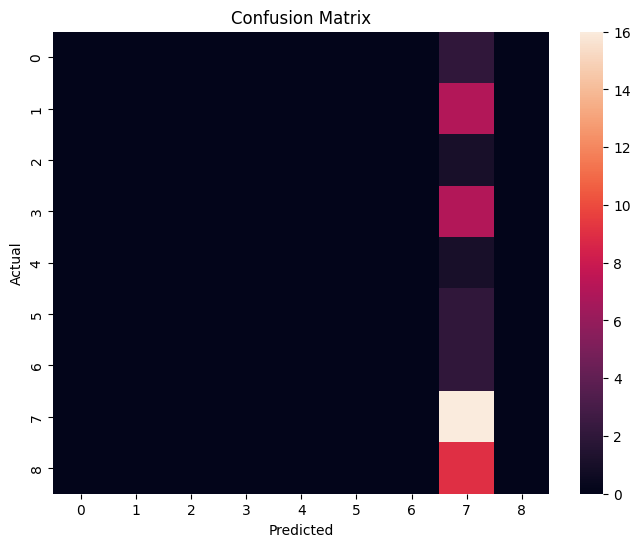

In [39]:
# Confusion matrix heatmap
cm = confusion_matrix(y_true, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classical Machine Learning Approach
Uses TF-IDF features of the symptoms text to train a logistic regression classifier

In [40]:
# Reload processed splits
train_df = pd.read_csv('./data/processed/train.csv')
val_df   = pd.read_csv('./data/processed/val.csv')
test_df  = pd.read_csv('./data/processed/test.csv')

# Build label dictionary from medical conditions in train
medical_conditions = sorted(train_df['medical_condition'].dropna().unique())
label_to_id = {cond: i for i, cond in enumerate(medical_conditions)}
id_to_label = {i: cond for cond, i in label_to_id.items()}


In [41]:
# Filter rows
train_df = train_df[train_df['medical_condition'].isin(label_to_id)]
val_df   = val_df[val_df['medical_condition'].isin(label_to_id)]
test_df  = test_df[test_df['medical_condition'].isin(label_to_id)]

# Remove empty symptoms
train_df = train_df[train_df['symptoms'].notna() & (train_df['symptoms'].str.strip() != "")]
val_df   = val_df[val_df['symptoms'].notna() & (val_df['symptoms'].str.strip() != "")]
test_df  = test_df[test_df['symptoms'].notna() & (test_df['symptoms'].str.strip() != "")]

# Encode labels
y_train = train_df['medical_condition'].map(label_to_id)
y_val   = val_df['medical_condition'].map(label_to_id)
y_test  = test_df['medical_condition'].map(label_to_id)

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train = tfidf_vectorizer.fit_transform(train_df['symptoms'])
X_val   = tfidf_vectorizer.transform(val_df['symptoms'])
X_test  = tfidf_vectorizer.transform(test_df['symptoms'])

In [45]:
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


In [46]:
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

In [47]:
# Metrics
accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds, average='macro', zero_division=0)
recall = recall_score(y_test, test_preds, average='macro', zero_division=0)
f1 = f1_score(y_test, test_preds, average='macro', zero_division=0)

print('Accuracy:', round(accuracy, 4))
print('Precision:', round(precision, 4))
print('Recall:', round(recall, 4))
print('F1 Score:', round(f1, 4))

Accuracy: 0.1064
Precision: 0.0648
Recall: 0.0833
F1 Score: 0.0612


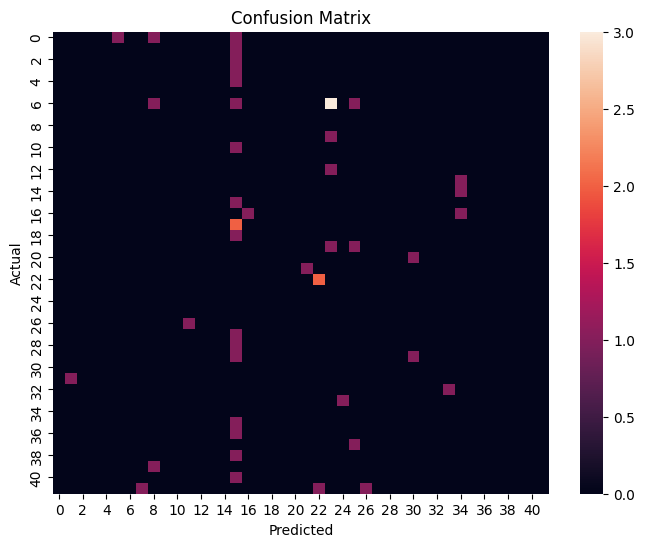

In [32]:
# Confusion matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Neural Network-based Deep Learning Approach
Fine-tunes a BERT text classification model to map symptoms to conditions